# Capacity prediction

## Notebook 5: Classification Model 

**Author:** ACG  
**Date:** `2024/06`  
**Version:** 1.0  

---

### Table of Contents
1. [Random Forest](#random-forest)
2. [XGBoost](#xgboost)

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from utils.properties import *
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
seed = 1862

## Import dataset

In [3]:
df = pd.read_csv(DATASET_FINAL, sep=';')
df_features = df.drop(['capacity'], axis=1)

## Transformation to a classification problem

We want to transform the target variable **'capacity'** into a categorical variable with 5 bins: 10 to 20, 20 to 30, 30 to 40, 40 to 50 and 50 +

In [4]:
df['capacity'].describe()

count    588.000000
mean      32.005102
std        7.193479
min       15.000000
25%       26.000000
50%       32.000000
75%       37.000000
max       53.000000
Name: capacity, dtype: float64

In [5]:
df['capacity_level'] = df['capacity'].apply(lambda x: '0_25' if x < 25 
                                            else '25_30' if x >= 25 and x < 30 
                                            else '30_35' if x >= 30 and x < 35
                                            else '35_40' if x >= 35 and x < 40
                                            else '40_60')

In [6]:
df[['capacity','capacity_level']]

,capacity,capacity_level
0,38,35_40
1,38,35_40
2,35,35_40
3,35,35_40
4,35,35_40
...,...,...
583,30,30_35
584,25,25_30
585,30,30_35
586,30,30_35


In [7]:
df['capacity_level'].value_counts()

capacity_level
35_40    123
30_35    123
25_30    121
40_60    113
0_25     108
Name: count, dtype: int64

In [8]:
bins = ['0_25','25_30','30_35','35_40','40_60']
bins

['35_40', '30_35', '25_30', '40_60', '0_25']

In [9]:
df_target = df['capacity_level']
df = df.drop(['capacity'], axis=1)

# 1. Random Forest <a id="random-forest"></a>

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

## Train

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)
rf_base = RandomForestClassifier(random_state=seed)

In [12]:
params = {
    'n_estimators': [50,100,150],
    'criterion': ['gini','entropy'],
    'max_depth':[5, 8, 13, 20],
    'min_samples_split':[2, 4, 8, 16, 40]
}
metrics = ['accuracy','precision_macro','recall']

In [13]:
grid = GridSearchCV(
    estimator=rf_base,
    param_grid=params,
    cv=5,
    scoring=metrics,
    refit='accuracy'
)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1862),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 8, 13, 20],
                         'min_samples_split': [2, 4, 8, 16, 40],
                         'n_estimators': [50, 100, 150]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall'])

## Evaluation

In [14]:
best_model_tr = grid.best_estimator_
y_pred = best_model_tr.predict(x_test)

print(best_model_tr)
print(f"parameters: {grid.best_params_}")
print(f"Accuracy: {grid.best_score_}")

RandomForestClassifier(max_depth=20, n_estimators=150, random_state=1862)
parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.6531914893617021


In [16]:
# top 5 results by accuracy
results = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_accuracy', ascending=False)
print(results.columns)
results[['param_criterion','param_n_estimators','param_max_depth','mean_test_accuracy','mean_test_precision_macro']].head(5)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy', 'split0_test_precision_macro',
       'split1_test_precision_macro', 'split2_test_precision_macro',
       'split3_test_precision_macro', 'split4_test_precision_macro',
       'mean_test_precision_macro', 'std_test_precision_macro',
       'rank_test_precision_macro', 'split0_test_recall', 'split1_test_recall',
       'split2_test_recall', 'split3_test_recall', 'split4_test_recall',
       'mean_test_recall', 'std_test_recall', 'rank_test_recall'],
      dtype='object')


,param_criterion,param_n_estimators,param_max_depth,mean_test_accuracy,mean_test_precision_macro
47,gini,150,20,0.653191,0.665599
32,gini,150,13,0.648936,0.662952
45,gini,50,20,0.646809,0.660139
50,gini,150,20,0.646809,0.662177
75,entropy,50,8,0.640426,0.649761


### Confusion matrix

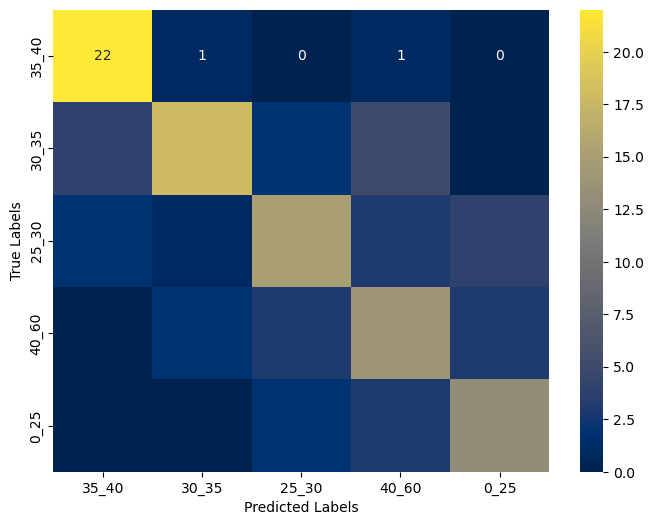

In [18]:
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8,6))
sbn.heatmap(cm,annot=True,cmap='cividis',xticklabels=bins,yticklabels=bins)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Features importances

In [19]:
from utils.eda_utils import plot_features_imp

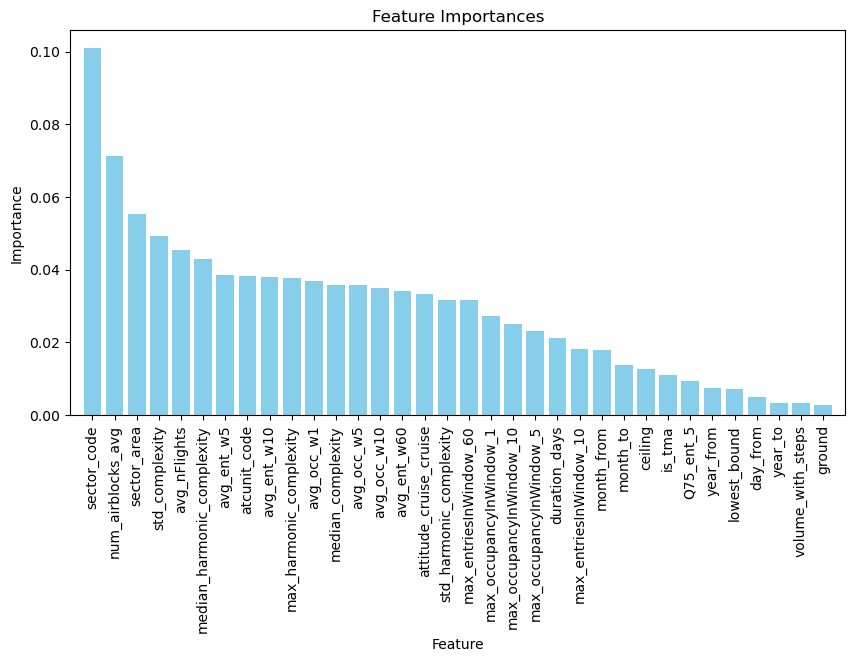

In [20]:
# train the best model
rfc = RandomForestClassifier(n_estimators=150,criterion='gini',max_depth=13,min_samples_split=4,random_state=seed)
rfc.fit(x_train,y_train)

# Get feature importances
importances = rfc.feature_importances_
plot_features_imp(importances,x_train)

# 2. XGBoost <a id="xgboost"></a>

In [21]:
from xgboost import XGBClassifier

In [22]:
# aplicar label encoding a target
df['capacity_le'] = df_target.replace(['0_25','25_30','30_35','35_40','40_60'], [0,1,2,3,4])

In [23]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df['capacity_le'], test_size=0.2, random_state=seed)

In [24]:
xgb_base = XGBClassifier(random_state=seed)
params = {
    'n_estimators': [50,100,150],
    'max_depth':[5, 8, 13, 20],
    'criterion':['gini','entropy'],
    'min_samples_split':[2, 4, 8, 16, 40]
}
metrics = ['accuracy','precision_macro','recall_macro']

In [25]:
grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=params,
    cv=5,
    scoring=metrics,
    refit='accuracy'
)
grid_xgb.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1862, ...),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 8, 13, 20],
                         'min_samples_split': [2, 4, 8, 16, 40],
                         'n_estimators': [50, 100, 150]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro'])

In [26]:
best_model_tr = grid_xgb.best_estimator_
y_pred = best_model_tr.predict(x_test)

print(best_model_tr)
print(f"parameters: {grid_xgb.best_params_}")
print(f"Accuracy: {grid_xgb.best_score_}")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, criterion='gini', device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, min_samples_split=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, ...)
parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.7191489361702128


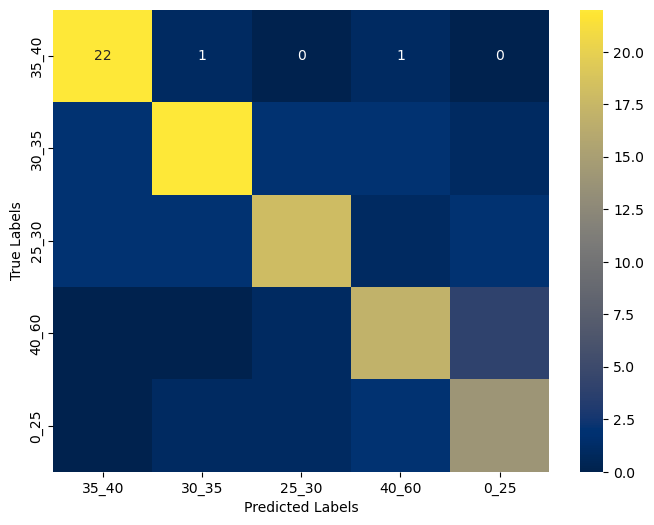

In [27]:
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8,6))
sbn.heatmap(cm,annot=True,cmap='cividis',xticklabels=bins,yticklabels=bins)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Features importances

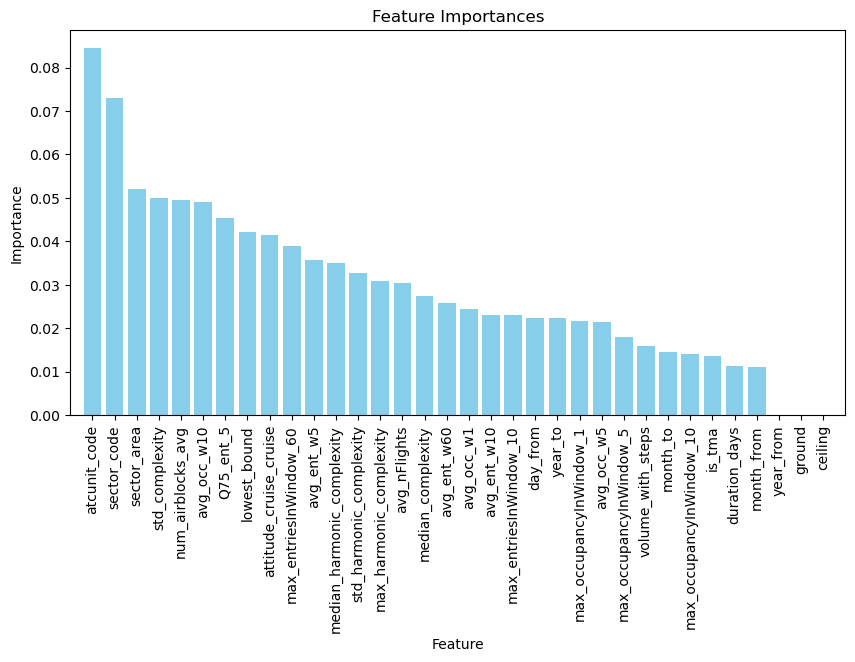

In [28]:
# best model
xgb = XGBClassifier(n_estimators=50,criterion='gini',max_depth=5,min_samples_split=2,random_state=seed)
xgb.fit(x_train,y_train)

importances = xgb.feature_importances_
plot_features_imp(importances,x_train)